# Storage Benchmark


In this notebook, we'll compare the following storage formats:

- CSV: Comma-separated, standard flat text file format.
- HDF5: Hierarchical data format, developed initially at the National Center for Supercomputing Applications. It is a fast and scalable storage format for numerical data, available in pandas using the PyTables library.
- Parquet: Part of the Apache Hadoop ecosystem, a binary, columnar storage format that provides efficient data compression and encoding and has been developed by Cloudera and Twitter. It is available for pandas through the `pyarrow` library, led by Wes McKinney, the original author of pandas.

This notebook compares the performance of the preceding libraries using a test DataFrame that can be configured to contain numerical or text data, or both. For the HDF5 library, we test both the fixed and table formats. The table format allows for queries and can be appended to.

## Usage

To recreate the charts used in the book, you need to run this notebook twice up to section 'Store Result' using different settings for `data_type` and arguments for `generate_test_data` as follows:

1. `data_type='Numeric`: `numerical_cols=2000`, `text_cols=0` (default)
2. `data_type='Mixed`: `numerical_cols=1000`, `text_cols=1000`


## Imports & Settings


In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import string

In [3]:
sns.set_style("whitegrid")

In [4]:
results = {}

## Generate Test Data


The test `DataFrame` that can be configured to contain numerical or text data, or both. For the HDF5 library, we test both the fixed and table format.


In [5]:
def generate_test_data(nrows=100000, numerical_cols=2000, text_cols=0, text_length=10):
    s = "".join([random.choice(string.ascii_letters) for _ in range(text_length)])
    data = pd.concat(
        [
            pd.DataFrame(np.random.random(size=(nrows, numerical_cols))),
            pd.DataFrame(np.full(shape=(nrows, text_cols), fill_value=s)),
        ],
        axis=1,
        ignore_index=True,
    )
    data.columns = [str(i) for i in data.columns]
    return data

In [6]:
data_type = "Numeric"

In [7]:
df = generate_test_data(numerical_cols=2000, text_cols=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 2000 entries, 0 to 1999
dtypes: float64(2000)
memory usage: 1.5 GB


## Parquet


### Size


In [8]:
parquet_file = Path("../../data/test.parquet")

In [9]:
df.to_parquet(parquet_file)
size = parquet_file.stat().st_size

### Read


In [10]:
%%timeit -o
df = pd.read_parquet(parquet_file)

769 ms ± 24.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 769 ms ± 24.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [11]:
read = _

In [12]:
parquet_file.unlink()

### Write


In [13]:
%%timeit -o
df.to_parquet(parquet_file)
parquet_file.unlink()

7.91 s ± 57.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 7.91 s ± 57.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [14]:
write = _

### Results


In [15]:
results["Parquet"] = {
    "read": np.mean(read.all_runs),
    "write": np.mean(write.all_runs),
    "size": size,
}

## HDF5


In [16]:
test_store = Path("../../data/index.h5")

### Fixed Format


#### Size


In [17]:
with pd.HDFStore(test_store) as store:
    store.put("file", df)
size = test_store.stat().st_size

#### Read


In [18]:
%%timeit -o
with pd.HDFStore(test_store) as store:
    store.get('file')

1.84 s ± 9.32 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 1.84 s ± 9.32 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [19]:
read = _

In [20]:
test_store.unlink()

#### Write


In [21]:
%%timeit -o
with pd.HDFStore(test_store) as store:
    store.put('file', df)
test_store.unlink()

2.36 s ± 473 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 2.36 s ± 473 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [22]:
write = _

#### Results


In [23]:
results["HDF Fixed"] = {
    "read": np.mean(read.all_runs),
    "write": np.mean(write.all_runs),
    "size": size,
}

### Table Format


#### Size


In [24]:
with pd.HDFStore(test_store) as store:
    store.append("file", df, format="t")
size = test_store.stat().st_size

#### Read


In [25]:
%%timeit -o
with pd.HDFStore(test_store) as store:
    df = store.get('file')

459 ms ± 9.22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 459 ms ± 9.22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [26]:
read = _

In [27]:
test_store.unlink()

#### Write


Note that `write` in table format does not work with text data.


In [28]:
%%timeit -o
with pd.HDFStore(test_store) as store:
    store.append('file', df, format='t')
test_store.unlink()    

1.69 s ± 86.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 1.69 s ± 86.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [29]:
write = _

#### Results


In [30]:
results["HDF Table"] = {
    "read": np.mean(read.all_runs),
    "write": np.mean(write.all_runs),
    "size": size,
}

### Table Select


#### Size


In [31]:
with pd.HDFStore(test_store) as store:
    store.append("file", df, format="t", data_columns=["company", "form"])
size = test_store.stat().st_size

#### Read


In [32]:
company = "APPLE INC"

In [33]:
%%timeit
with pd.HDFStore(test_store) as store:
    s = store.get('file')

474 ms ± 29.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
read = _

In [35]:
test_store.unlink()

#### Write


In [36]:
%%timeit
with pd.HDFStore(test_store) as store:
    store.append('file', df, format='t', data_columns=['company', 'form'])
test_store.unlink() 

1.69 s ± 64.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
write = _

#### Results


In [38]:
results["HDF Select"] = {
    "read": np.mean(read.all_runs),
    "write": np.mean(write.all_runs),
    "size": size,
}

## CSV


In [39]:
test_csv = Path("test.csv")

### Size


In [40]:
df.to_csv(test_csv)
test_csv.stat().st_size

3854666936

### Read


In [41]:
%%timeit -o
df = pd.read_csv(test_csv)

17.9 s ± 359 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 17.9 s ± 359 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [42]:
read = _

In [43]:
test_csv.unlink()

### Write


In [44]:
%%timeit -o
df.to_csv(test_csv)
test_csv.unlink()

1min 47s ± 1.27 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 1min 47s ± 1.27 s per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [45]:
write = _

### Results


In [46]:
results["CSV"] = {
    "read": np.mean(read.all_runs),
    "write": np.mean(write.all_runs),
    "size": size,
}

## Store Results


In [47]:
pd.DataFrame(results).assign(Data=data_type).to_csv(f"{data_type}.csv")

## Display Results


Please run the notebook twice as described above under `Usage` to create the two `csv` files with results for different test data.


In [49]:
pd.concat(
    [pd.read_csv("Numeric.csv", index_col=0), pd.read_csv("Mixed.csv", index_col=0)]
).rename(columns=str.capitalize)

,Parquet,Hdf fixed,Hdf table,Hdf select,Csv,Data
read,7.693752e-01,1.843223e+00,4.589618e-01,1.686235e+00,1.787215e+01,Numeric
write,7.905895e+00,2.361741e+00,1.686235e+00,1.686235e+00,1.075421e+02,Numeric
size,2.026791e+09,1.600821e+09,1.601034e+09,1.601034e+09,1.601034e+09,Numeric
read,2.208935e+00,8.308703e+01,1.930407e+01,3.226779e+01,1.535536e+01,Numeric
write,1.216895e+01,2.138260e+01,3.226779e+01,3.226779e+01,6.575975e+01,Numeric
size,1.013993e+09,2.102252e+09,1.801425e+09,1.801425e+09,1.801425e+09,Numeric


In [69]:
df = pd.concat(
    [pd.read_csv("Numeric.csv", index_col=0), pd.read_csv("Mixed.csv", index_col=0)]
).rename(columns=str.capitalize)
df.index.name = "Storage"
df = df.set_index("Data", append=True).unstack()
df.loc["size", :] /= 1e9

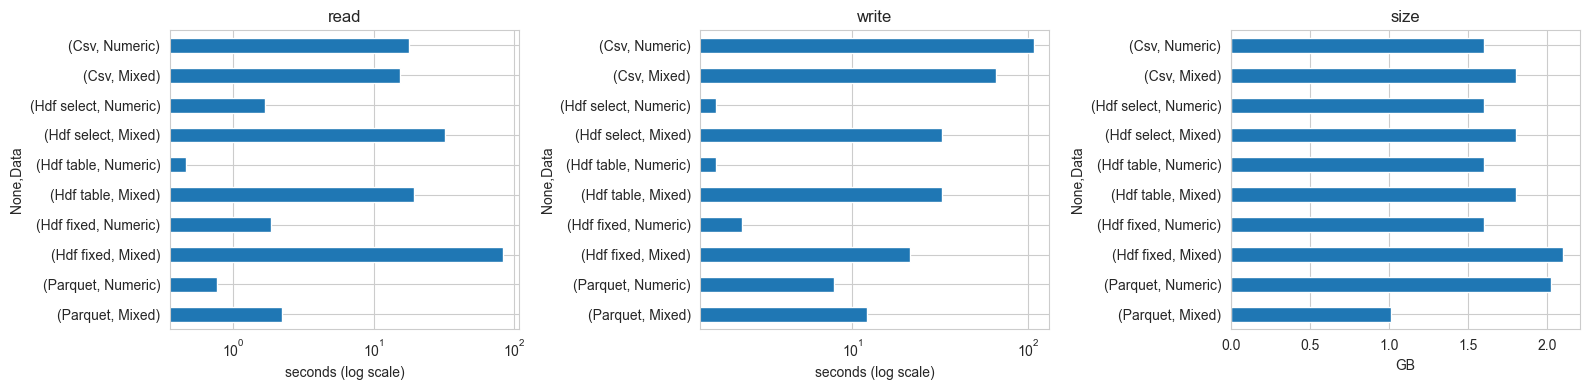

In [71]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 4))
for i, op in enumerate(["read", "write", "size"]):
    flag = op in ["read", "write"]
    df.loc[op, :].plot.barh(title=op, ax=axes[i], logx=flag)
    if flag:
        axes[i].set_xlabel("seconds (log scale)")
    else:
        axes[i].set_xlabel("GB")
fig.tight_layout()
fig.savefig("storage", dpi=300)
plt.show()